# Iceberg for Spark: Performance Comparison Tutorial
In this notebook, we will compare performance between classic Spark tables and Iceberg tables.

First, install Docker and Docker Compose. Next, create a docker-compose.yaml file with the contents of https://iceberg.apache.org/spark-quickstart/. Use ̀`docker-compose up` to install all necessary files.

You can also launch a notebook server by running docker exec -it spark-iceberg notebook. The notebook server will be available at http://localhost:8888

In [1]:
import io
import random
from  pyspark.sql.types import StructType,StructField,IntegerType,FloatType 
import time
import statistics as stats
import matplotlib.pyplot as plt

## Program settings

In [2]:
# Number of run for stat on query, must be > 1
NUM_MES = 16
# Number of Size Test
NUM_RUN =  8  
# Number of computed rows
BASE_SIZE = 70000 
# Increase at each step
SAMPLING_RATIO = 1.
# 1 hour computation for thoses values

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Jupyter").getOrCreate()

spark

23/10/15 21:14:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
%%sql
CREATE DATABASE IF NOT EXISTS db

++
||
++
++

## Generation of the first dataset
We will start by generating a synthetic dataset with the following columns:

- A Gaussian value
- Three categorical variables with varying cardinalities, obtained from binomial distributions

> Those who are curious can consult the [Galton board](https://en.wikipedia.org/wiki/Galton_board) for a visual explanation on binomial distribution.

The dataset generation function is as follows:

In [5]:
res_by_queries = {}

output_buffer = io.StringIO()
original_stdout = sys.stdout

current_size =   BASE_SIZE 

def gen_binomial(n,p):
    return sum(1 for _ in range(n) if random.random() < p)

try:
       data = [( random.normalvariate(50,10),
                   gen_binomial(4,.5),gen_binomial(50,.5),gen_binomial(200,.5)) for i in range(int(current_size))      ]
       schema = StructType([StructField("Value", FloatType(), False),
           StructField("low_card", IntegerType(), False),StructField("medium_card", IntegerType(), False),StructField("high_card", IntegerType(), False)])
       base = spark.createDataFrame(data, schema)

except Exception as e:
        print("Une erreur s'est produite lors de la génération du DataFrame :", str(e))

#base.write.mode("overwrite").parquet("ds.parquet",compression="none") # or  "uncompressed"

base_size = current_size * (4 + 3 *4)

df_size_bytes = base_size

We estimate the dataset size to be around 16 bytes per row.

To quickly change the size of the dataset, we will add part of its current contents in each iteration using `base = base.union(base.sample(SAMPLING_RATIO))`. This approach allows us to observe how performance scales with the size of the dataset.

## Requests
The requests that we will use to carry out our tests:

In [6]:
# List of queries to execute
queries = [
    ("Q1", "SELECT *", " WHERE low_card = 2 "),
    ("Q2", "SELECT * ", "WHERE medium_card = 25 "),
    ("Q3", "SELECT * ", "WHERE high_card = 100 "),
    ("Q4", "SELECT low_card, AVG(value)", "GROUP BY low_card "),
    ("Q5", "SELECT medium_card, AVG(value)", " GROUP BY medium_card "),
    ("Q6", "SELECT high_card, AVG(value) ", "GROUP BY high_card "),
]

In [7]:
print(base.describe().show())
base_size = current_size * (4 + 3 *4)

df_size_bytes = base_size

print("Size in MiB", df_size_bytes/1024./1024.)

df = base.alias("copy")

23/10/15 21:14:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+-----------------+
|summary|             Value|         low_card|       medium_card|        high_card|
+-------+------------------+-----------------+------------------+-----------------+
|  count|             70000|            70000|             70000|            70000|
|   mean|50.038421843106406|2.001314285714286|25.010285714285715|99.98201428571429|
| stddev| 9.932333364096555|1.001704850302162| 3.527907191067214|7.036760488406463|
|    min|          9.111355|                0|                10|               71|
|    max|          88.19616|                4|                40|              134|
+-------+------------------+-----------------+------------------+-----------------+

None
Size in MiB 1.068115234375


In [8]:
%%time
for i in range(NUM_RUN):
    #    try :\n#        gc.collect()\n#    except:\n#        print("*** ERROR in gc.collect() ***")   \n\n#    
    df_size_bytes = df_size_bytes + df_size_bytes
    print (f"run {i+1}/{NUM_RUN}")
    
    df = df.union(df.sample(SAMPLING_RATIO))
    df_size_bytes = df_size_bytes + SAMPLING_RATIO * df_size_bytes
    
    df.createOrReplaceTempView("df")
    
    spark.sql("DROP TABLE  IF EXISTS db.table PURGE")
    df.writeTo("db.table").using("iceberg").create()

    #"requete à blanc"
    spark.sql("SELECT * FROM db.table WHERE low_card >1")
    
    for q_name,q_start,q_end in queries:
        print(f"Running new test :",q_name)
        show_duration_iceberg = []
        show_duration_base = []
#       gc.disable()
        for _ in range(NUM_MES):
            result = spark.sql(q_start + " FROM db.table "+q_end)
            start_time = time.time()
            result.show()
            end_time = time.time()
            show_duration_iceberg.append(end_time - start_time)
            sys.stdout = output_buffer
        sys.stdout = original_stdout
        
        for _ in range(NUM_MES):
            result = spark.sql(q_start + " FROM df "+q_end)
            start_time = time.time()
            result.show()
            end_time = time.time()
            show_duration_base.append(end_time - start_time)
            sys.stdout = output_buffer
#       gc.enable()    
        sys.stdout = original_stdout
        computed_ratio = [  show_duration_base[i] / show_duration_iceberg[i] for i in range(len(show_duration_base))]
        
        res = f"{float(df_size_bytes)};{stats.mean(show_duration_iceberg)};{stats.stdev(show_duration_iceberg)};{stats.mean(show_duration_base)};{stats.stdev(show_duration_base)};{stats.mean(computed_ratio)}; { stats.stdev(computed_ratio)};"
        print(res)
        old_dic = res_by_queries.get(q_name, {})
        old_dic[df_size_bytes] = res
        res_by_queries[q_name] = old_dic

run 1/8


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+

4480000.0;0.3305841237306595;0.11236607557365619;0.28770580887794495;0.06109652131435602;0.9285891744524079; 0.2637856203744989;
Running new test : Q5
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         26| 50.24433552034602|
|         28| 50.21440078194323|
|         23| 50.06367842181931|
|         24| 49.88100858075143|
|         21|  50.0165472555598|
|         27| 49.79181842897578|
|         20| 50.06146111848921|
|         22| 50.05493654791968|
|         25| 50.08941869776856|
|         33|50.017583517858824|
|         17|49.799143438998605|
|         29| 50.30844337576448|
|         31| 49.82182654751001|
|         18| 49.96899963531633|
|         30| 50.

Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+

17920000.0;0.41384220123291016;0.09599601736999934;0.39513929188251495;0.0661075948575455;1.0002144601577572; 0.26962421634531836;
Running new test : Q5
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         26| 50.24433552034602|
|         28| 50.21440078194323|
|         23| 50.06367842181931|
|         24| 49.88100858075143|
|         21|  50.0165472555598|
|         27| 49.79181842897578|
|         20| 50.06146111848921|
|         22| 50.05493654791968|
|         25| 50.08941869776856|
|         33|50.017583517858824|
|         17|49.799143438998605|
|         29| 50.30844337576448|
|         31| 49.82182654751001|
|         18| 49.96899963531633|
|         30| 5

Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



71680000.0;0.39239610731601715;0.04313934677578998;0.6796753853559494;0.08995168511883563;1.743871082985163; 0.24681757633422927;
Running new test : Q5
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
|         29| 50.30844337576448|
+-----------+------------------+
only showing top 20 rows



71680000.0;0.35959726572036743;0.09738533484337678;0.7230351120233536;0.07171801769094403;2.1017642823278875; 0.3912282284155006;
Running new test : Q6
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
|      112| 49.83223221722771|
+---------+------------------+
only showing top 20 rows



71680000.0;0.34023649990558624;0.043705205963726936;0.803919643163681;0.09596249494020857;2.406576710809607; 0.4677223654703681;
run 4/8


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



286720000.0;0.37381526827812195;0.07428745107848005;1.3787874728441238;0.23953448586926274;3.763813642782423; 0.7113776303650997;
Running new test : Q5
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
|         29| 50.30844337576448|
+-----------+------------------+
only showing top 20 rows



286720000.0;0.3491268903017044;0.03875036292031148;1.4132404327392578;0.13505354038719722;4.0909059144783235; 0.5616603665873589;
Running new test : Q6
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
|      112| 49.83223221722771|
+---------+------------------+
only showing top 20 rows



286720000.0;0.3702951818704605;0.052077626338286664;1.5717024207115173;0.2226091385048447;4.344868110988831; 1.0220653878606514;
run 5/8


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



1146880000.0;0.538727343082428;0.11032198482463787;2.6353153437376022;0.26082645907043556;5.031888006826966; 0.8147494481274705;
Running new test : Q5
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
|         29| 50.30844337576448|
+-----------+------------------+
only showing top 20 rows



1146880000.0;0.5148303508758545;0.06919767837709288;2.8790890872478485;0.30024762421780343;5.674229746170236; 0.8798719345839814;
Running new test : Q6
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
|      112| 49.83223221722771|
+---------+------------------+
only showing top 20 rows



1146880000.0;0.5526349246501923;0.08144464662283918;3.3605019003152847;0.2500994382515115;6.199671816544068; 0.9937200636926784;
run 6/8


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



4587520000.0;0.977698564529419;0.13112972530913805;6.881060063838959;0.5197882396447538;7.15940607898835; 1.1288085395042358;
Running new test : Q5


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
|         29| 50.30844337576448|
+-----------+------------------+
only showing top 20 rows



4587520000.0;1.024229720234871;0.1216512690814214;7.334216311573982;0.4953432539224881;7.229674050765215; 0.7952864146624212;
Running new test : Q6


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
|      112| 49.83223221722771|
+---------+------------------+
only showing top 20 rows



4587520000.0;1.1077285259962082;0.14904597129775365;8.053144052624702;0.5287631389222406;7.398415828169226; 1.1464177759801844;
run 7/8


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



18350080000.0;1.9723969399929047;0.20357176180050784;16.42173781991005;0.642959170165167;8.414948873149124; 0.9907277109895346;
Running new test : Q5


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
|         29| 50.30844337576448|
+-----------+------------------+
only showing top 20 rows



18350080000.0;2.110830083489418;0.1519961008783666;17.70041312277317;0.8940170142907056;8.43003466957199; 0.7797505097812037;
Running new test : Q6


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|      128| 29.71042251586914|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



18350080000.0;2.0653257369995117;0.10111739055419322;19.133857920765877;1.0609737194983655;9.282094095668864; 0.6440972874905085;
run 8/8


Running new test : Q1
+---------+--------+-----------+---------+
|    Value|low_card|medium_card|high_card|
+---------+--------+-----------+---------+
|58.198185|       2|         26|      119|
|57.164455|       2|         21|      105|
|49.885857|       2|         27|      105|
|47.437115|       2|         24|      105|
| 53.27555|       2|         22|       89|
|53.189037|       2|         23|       91|
|  42.0384|       2|         22|      102|
| 56.41985|       2|         20|       94|
|24.779928|       2|         22|       89|
| 49.51744|       2|         27|      102|
| 56.14803|       2|         24|      104|
| 42.42758|       2|         21|      107|
| 58.16923|       2|         31|      103|
|53.344875|       2|         23|      104|
| 61.40092|       2|         18|      103|
|44.272724|       2|         28|       95|
| 44.32016|       2|         24|       98|
|58.663345|       2|         27|      100|
|60.066708|       2|         28|       95|
|57.149937|       2|         30|

+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



23/10/15 21:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


+--------+------------------+
|low_card|        avg(value)|
+--------+------------------+
|       1| 50.09222468567548|
|       3| 50.03075749545126|
|       4| 50.01863955647819|
|       2| 49.96828078134847|
|       0|50.291382594705034|
+--------+------------------+



23/10/15 21:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 21:57:51 WAR

73400320000.0;4.243679329752922;0.23026187090142541;42.63085199892521;1.4350458039094427;10.073547607335327; 0.6523212092080934;
Running new test : Q5


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         40| 45.65312576293945|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         10| 45.79282760620117|
|         38| 50.74249267578125|
+-----------+------------------+
only showing top 20 rows



23/10/15 22:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31| 49.82182654751001|
|         34| 49.64644256764631|
|         28| 50.21440078194323|
|         26| 50.24433552034602|
|         27| 49.79181842897578|
|         12|51.776974784003365|
|         22| 50.05493654791968|
|         13|49.654107823091394|
|         16| 49.15498290743147|
|         20| 50.06146111848921|
|         19|49.698352211319815|
|         15| 49.75458926325259|
|         37| 48.76517105102539|
|         17|49.799143438998605|
|         35| 51.16140880584717|
|         23| 50.06367842181931|
|         39|61.097251892089844|
|         40| 45.65312576293945|
|         25| 50.08941869776856|
|         24| 49.88100858075143|
+-----------+------------------+
only showing top 20 rows



23/10/15 22:02:42 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:04:11 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:08:49 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:10:21 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:11:09 WAR

73400320000.0;4.509554356336594;0.33518199692158246;47.13179163634777;2.8528995016908407;10.510143975006619; 1.0789573350149209;
Running new test : Q6


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      128| 29.71042251586914|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



23/10/15 22:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|       85| 50.07204122498562|
|       78| 46.81513845509496|
|      108|49.930148310315644|
|      101| 49.98242907891276|
|      115|51.152392504837714|
|      126| 46.48365926742554|
|       81| 50.07366745872835|
|       76|  48.9455982208252|
|      103|49.748138840621756|
|       91| 49.82190768594412|
|      122| 49.20256192343576|
|       93| 50.36989455283956|
|      111| 50.43391758784639|
|       86| 49.71774905119369|
|       94|50.084269044283424|
|      120|51.709403330485024|
|      128| 29.71042251586914|
|       96|50.121089703595196|
|       92| 49.92682753469538|
|      117| 49.35802821299476|
+---------+------------------+
only showing top 20 rows



23/10/15 22:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:19:47 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB
23/10/15 22:25:22 WAR

73400320000.0;4.562244936823845;0.36018557493518366;48.334868401288986;1.265268263320136;10.647295791131276; 0.7627033804438214;
CPU times: user 27.6 s, sys: 9.22 s, total: 36.8 s
Wall time: 1h 14min 1s


We collect the data to be able to visualize them.

In [32]:
size = [key for key in res_by_queries['Q1'].keys()]
size_MiB =  [v/1024/1024.for v in size]
size_GiB =  [v/1024/1024./1024 for v in size]

In [26]:
queries = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']

Q_dict = {}
STDQ_dict = {}

for query in queries:
    Q_dict[query] = []
    STDQ_dict[query] = []

    for k, v in res_by_queries[query].items():
        tab = v.split(";")
        Q_dict[query].append(float(tab[-3]))
        STDQ_dict[query].append(float(tab[-2]))

## Visualization

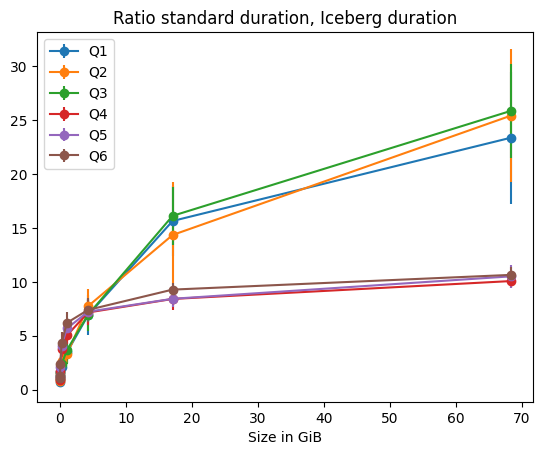

In [41]:
fig = plt.figure()
#fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
plt.errorbar(size_GiB, Q_dict['Q1'], yerr=STDQ_dict['Q1'], label='Q1',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q2'], yerr=STDQ_dict['Q2'], label='Q2',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q3'], yerr=STDQ_dict['Q3'], label='Q3',  fmt='-o')
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Size in GiB")
plt.errorbar(size_GiB, Q_dict['Q4'], yerr=STDQ_dict['Q4'], label='Q4',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q5'], yerr=STDQ_dict['Q5'], label='Q5',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q6'], yerr=STDQ_dict['Q6'], label='Q6',  fmt='-o')
plt.title('Ratio standard duration, Iceberg duration')
#plt.xlim(left=0) 
#plt.xlim(right=5)  
#plt.ylim(top=10)  
plt.legend()

> a 1 Go where  x 3, GB fois 5.5. Les courbes se croisent à 4.5 Go avec un gain d'environ 6.

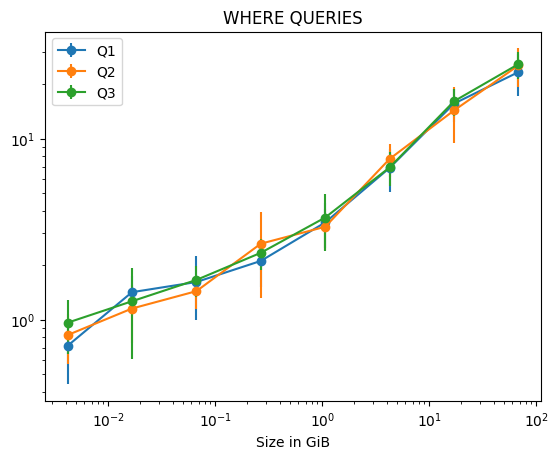

In [45]:
fig = plt.figure()
plt.errorbar(size_GiB, Q_dict['Q1'], yerr=STDQ_dict['Q1'], label='Q1',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q2'], yerr=STDQ_dict['Q2'], label='Q2',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q3'], yerr=STDQ_dict['Q3'], label='Q3',  fmt='-o')
plt.xscale("log") #, **kwargs)
plt.yscale("log") #, **kwargs)
plt.title('WHERE QUERIES')
plt.xlabel("Size in GiB")
plt.legend()

It is a progression in power depending on the size of the data set

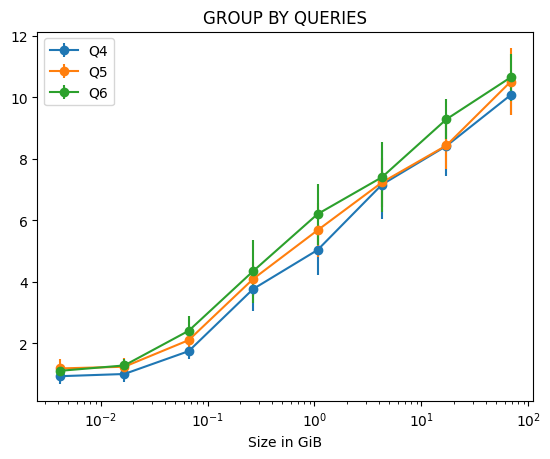

In [46]:
fig = plt.figure()
plt.errorbar(size_GiB, Q_dict['Q4'], yerr=STDQ_dict['Q4'], label='Q4',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q5'], yerr=STDQ_dict['Q5'], label='Q5',  fmt='-o')
plt.errorbar(size_GiB, Q_dict['Q6'], yerr=STDQ_dict['Q6'], label='Q6',  fmt='-o')
plt.xscale("log") 
plt.title('GROUP BY QUERIES')
plt.xlabel("Size in GiB")
plt.ylabel("Gain with Iceberg")
plt.legend()

`Group by` follow a log law depending on the size of the dataset.
We can observe that most of the time a GROUP BY with a large cardinality increases the gain.

For a small table ratio is not greater than 1, Iceberg is of little use. For larger tables, WHERE becomes faster, while GROUP BY becomes noticeably faster than for a default table.

The WHERE benefits from data pruning, while the GROUP BY is marked by the [bloom filter](https://en.wikipedia.org/wiki/Bloom_filter) which is all the more efficient as the cardinality is large.


In [30]:
 spark.sql("DROP TABLE  IF EXISTS db.table PURGE")

DataFrame[]

## Conclusion

Using the Docker image made available by Iceberg, we have an average gain of around 4, for a 1 GiB table. This remains modest.
On a [TDP](https://www.adaltas.com/en/tag/tdp/) cluster By extrapolating for a 1 GiB dataset, a gain of 10, as mentioned in the official documentation, is therefore common regardless of the query. Switching to Iceberg, even for a data warehouse, is therefore relevant.

The tutorial aims to help you understand Iceberg's performance benefits compared to Spark default tables. Note that running memory-intensive tasks on small clusters can lead to memory saturation, so it's essential to monitor memory usage and avoid computationally intensive operations. Spark recommends keeping tasks under 1 GiB in size to ensure smooth execution.

Feel free to modify parameters and explore different scenarios to better understand how Iceberg can enhance your large-scale data processing pipelines. For example you can perform multiple experiments:
- adjust settings,
- modify queries,
- measure the impact of the number of snapshots when creating the Iceberg table.
